# WikiArt Multimodal Retrieval

Этот ноутбук демонстрирует полный пайплайн решения: предобработка данных и работа трёх режимов поиска (Image -> Image, Caption -> Image, Omni -> Image).

Также тут продемонстрированы сгенерированные данные.

## 1. Импорт и подготовка окружения

In [ ]:
from pathlib import Path
import sys
import json
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.pipeline import build_corpus

In [ ]:
# Запускаем скрипт по предобработке данных
# Он будет стримить первые 5000 записей датасета wikiart, предобрабатывая каждую (создавая эмбеддинги к картикам, генерирую описания и эмбединги к ним, а также создавая теги)

build_corpus(sample_size=5000)

Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

Streaming WikiArt:   0%|          | 0/5000 [00:00<?, ?it/s]

## 2. Просмотр сгенерированных описаний и тегов

In [2]:
def print_separator():
    print("\n" + "="*40 + "\n")

def draw_image(image_path: str):
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def draw_image_line(image_paths: list[str], captions: list[str] | None = None):
    fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))
    for ax, image_path in zip(axes, image_paths):
        img = plt.imread(image_path)
        ax.imshow(img)
        ax.axis('off')
    if captions:
        for ax, caption in zip(axes, captions):
            ax.set_title(caption)
    plt.show()

def draw_image_grid(image_paths: list[list[str]], captions: list[list[str]] | None = None):
    cols, rows = len(image_paths), len(image_paths[0])
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    for i in range(rows):
        for j in range(cols):
            img = plt.imread(image_paths[j][i])
            if captions:
                axes[i, j].set_title(captions[j][i])
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
    plt.show()

Image path: artifacts\images\sample_0.jpg


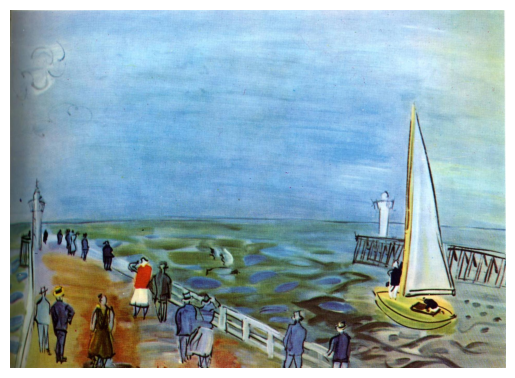

Caption: there is a painting of people walking on the beach with a sailboat


Image path: artifacts\images\sample_1.jpg


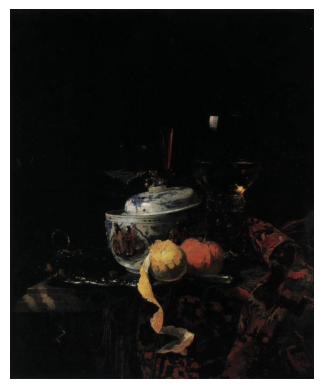

Caption: there is a painting of a bowl of fruit and a candle on a table


Image path: artifacts\images\sample_2.jpg


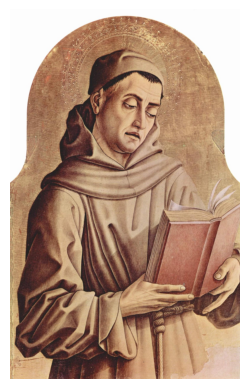

Caption: an image of a painting of a man reading a book


Image path: artifacts\images\sample_3.jpg


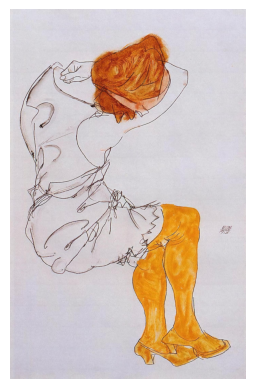

Caption: there is a drawing of a woman sitting on the ground with her legs crossed


Image path: artifacts\images\sample_4.jpg


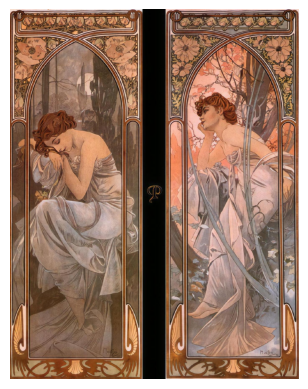

Caption: there are two paintings of a woman sitting on a bench




In [3]:
metadata_data = pd.read_parquet(project_root / "artifacts" / "datasets" / "omni_metadata.parquet")

for idx, row in metadata_data.head(5).iterrows():
    print(f"Image path: {row['image_path']}")
    draw_image(project_root / row['image_path'])
    print(f"Caption: {row['caption']}")
    print_separator()

Стоит отметить, что сами описания весьма общие, но при этом довольно хорошо совпадающие с самой картиной. В целом это и не хорошо и не плохо (система поиска будет работать лучше из-за отсутствия смещающих деталей, но при этом будет не супер точна).

Стоит также отметить, что не на всех картинках описательная модель справилась хоть сколько хорошо. Например, `sample_1.jpg` имеет некорректное описание (хотя и мне сложно понять, что там изображено).

In [4]:
with open(project_root / "artifacts" / "indexes" / "labels" / "omni_tags.json", "r", encoding="utf-8") as fin:
    omni_tags = json.load(fin)
    print(f"Tags: {', '.join(omni_tags)} ...")

Tags: vibrant colors, muted palette, monochrome tones, warm lighting, cool lighting, detailed portrait, crowded scene, solitary figure, dynamic movement, symmetrical composition, dreamlike atmosphere, somber mood, joyful energy, mysterious setting, romantic theme, mythological elements, religious symbolism, nature landscape, urban landscape, interior scene, thick brushstrokes, fine detail work, geometric abstraction, soft gradients ...


In [5]:
all_image_paths = metadata_data['image_path'].tolist()
all_captions = metadata_data['caption'].tolist()

## 3. Просмотр примеров работы Image2Image

Error loading artifacts\type_mappings\artist.csv: [Errno 2] No such file or directory: 'artifacts\\type_mappings\\artist.csv'
Error loading artifacts\type_mappings\genre.csv: [Errno 2] No such file or directory: 'artifacts\\type_mappings\\genre.csv'
Error loading artifacts\type_mappings\style.csv: [Errno 2] No such file or directory: 'artifacts\\type_mappings\\style.csv'
Initializing Annoy index: dim=512, metric=angular, n_trees=64
Initializing Annoy index: dim=512, metric=angular, n_trees=64




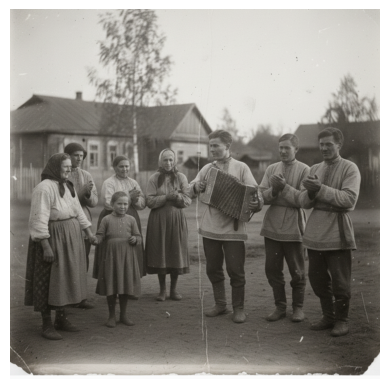

Reference image




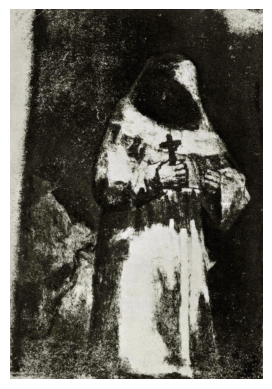

francisco-goya | Romanticism | genre_painting | there is a black and white drawing of a nun holding a cross | Tags: solitary figure, interior scene, detailed portrait




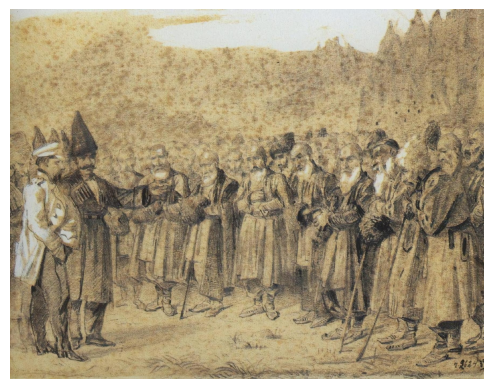

vasily-vereshchagin | Realism | genre_painting | there is a drawing of a group of men standing in front of a crowd | Tags: crowded scene, interior scene, detailed portrait




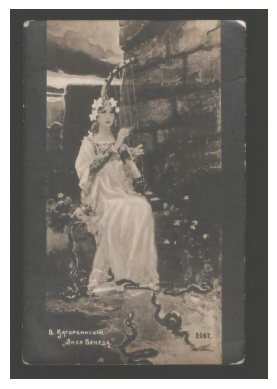

Unknown Artist | Art_Nouveau | genre_painting | there is an old photo of a woman sitting on a chair | Tags: romantic theme, interior scene, religious symbolism




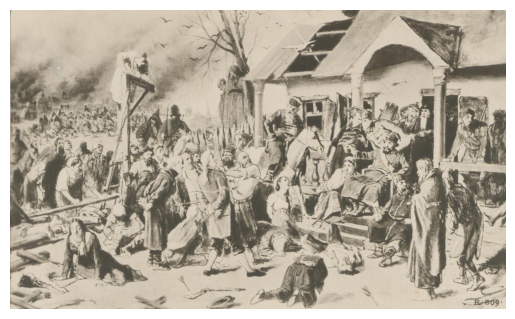

vasily-perov | Realism | genre_painting | there is a drawing of a crowd of people gathered around a building | Tags: crowded scene, interior scene, detailed portrait




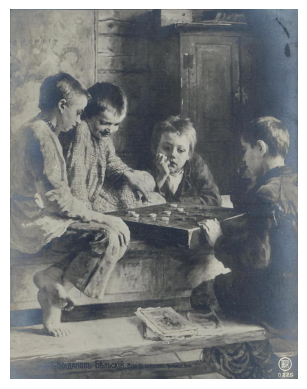

nikolay-bogdanov-belsky | Realism | genre_painting | this is an old photo of a group of children reading a book | Tags: interior scene, crowded scene, detailed portrait




In [6]:
from demo import image_to_image, set_new_mapping_location

set_new_mapping_location(project_root / "artifacts" / "type_mappings")

reference_image = str(project_root / "artifacts" / "test" / "test.png")
result = image_to_image(query_image=reference_image, top_k=5)

print_separator()
draw_image(reference_image)
print("Reference image")
print_separator()
for idx, (img_path, description) in enumerate(result[::-1]):
    draw_image(str(img_path))
    print(description)
    print_separator()

Результат довольно хороший: почти везде есть группа людей, сами картинки выполнены в монохромных тонах, а время найденных картин не напоминает современность (что подходит изначальной картинке).

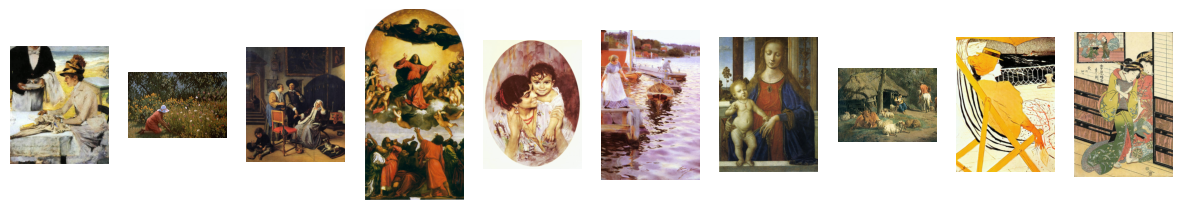

Random images from the corpus




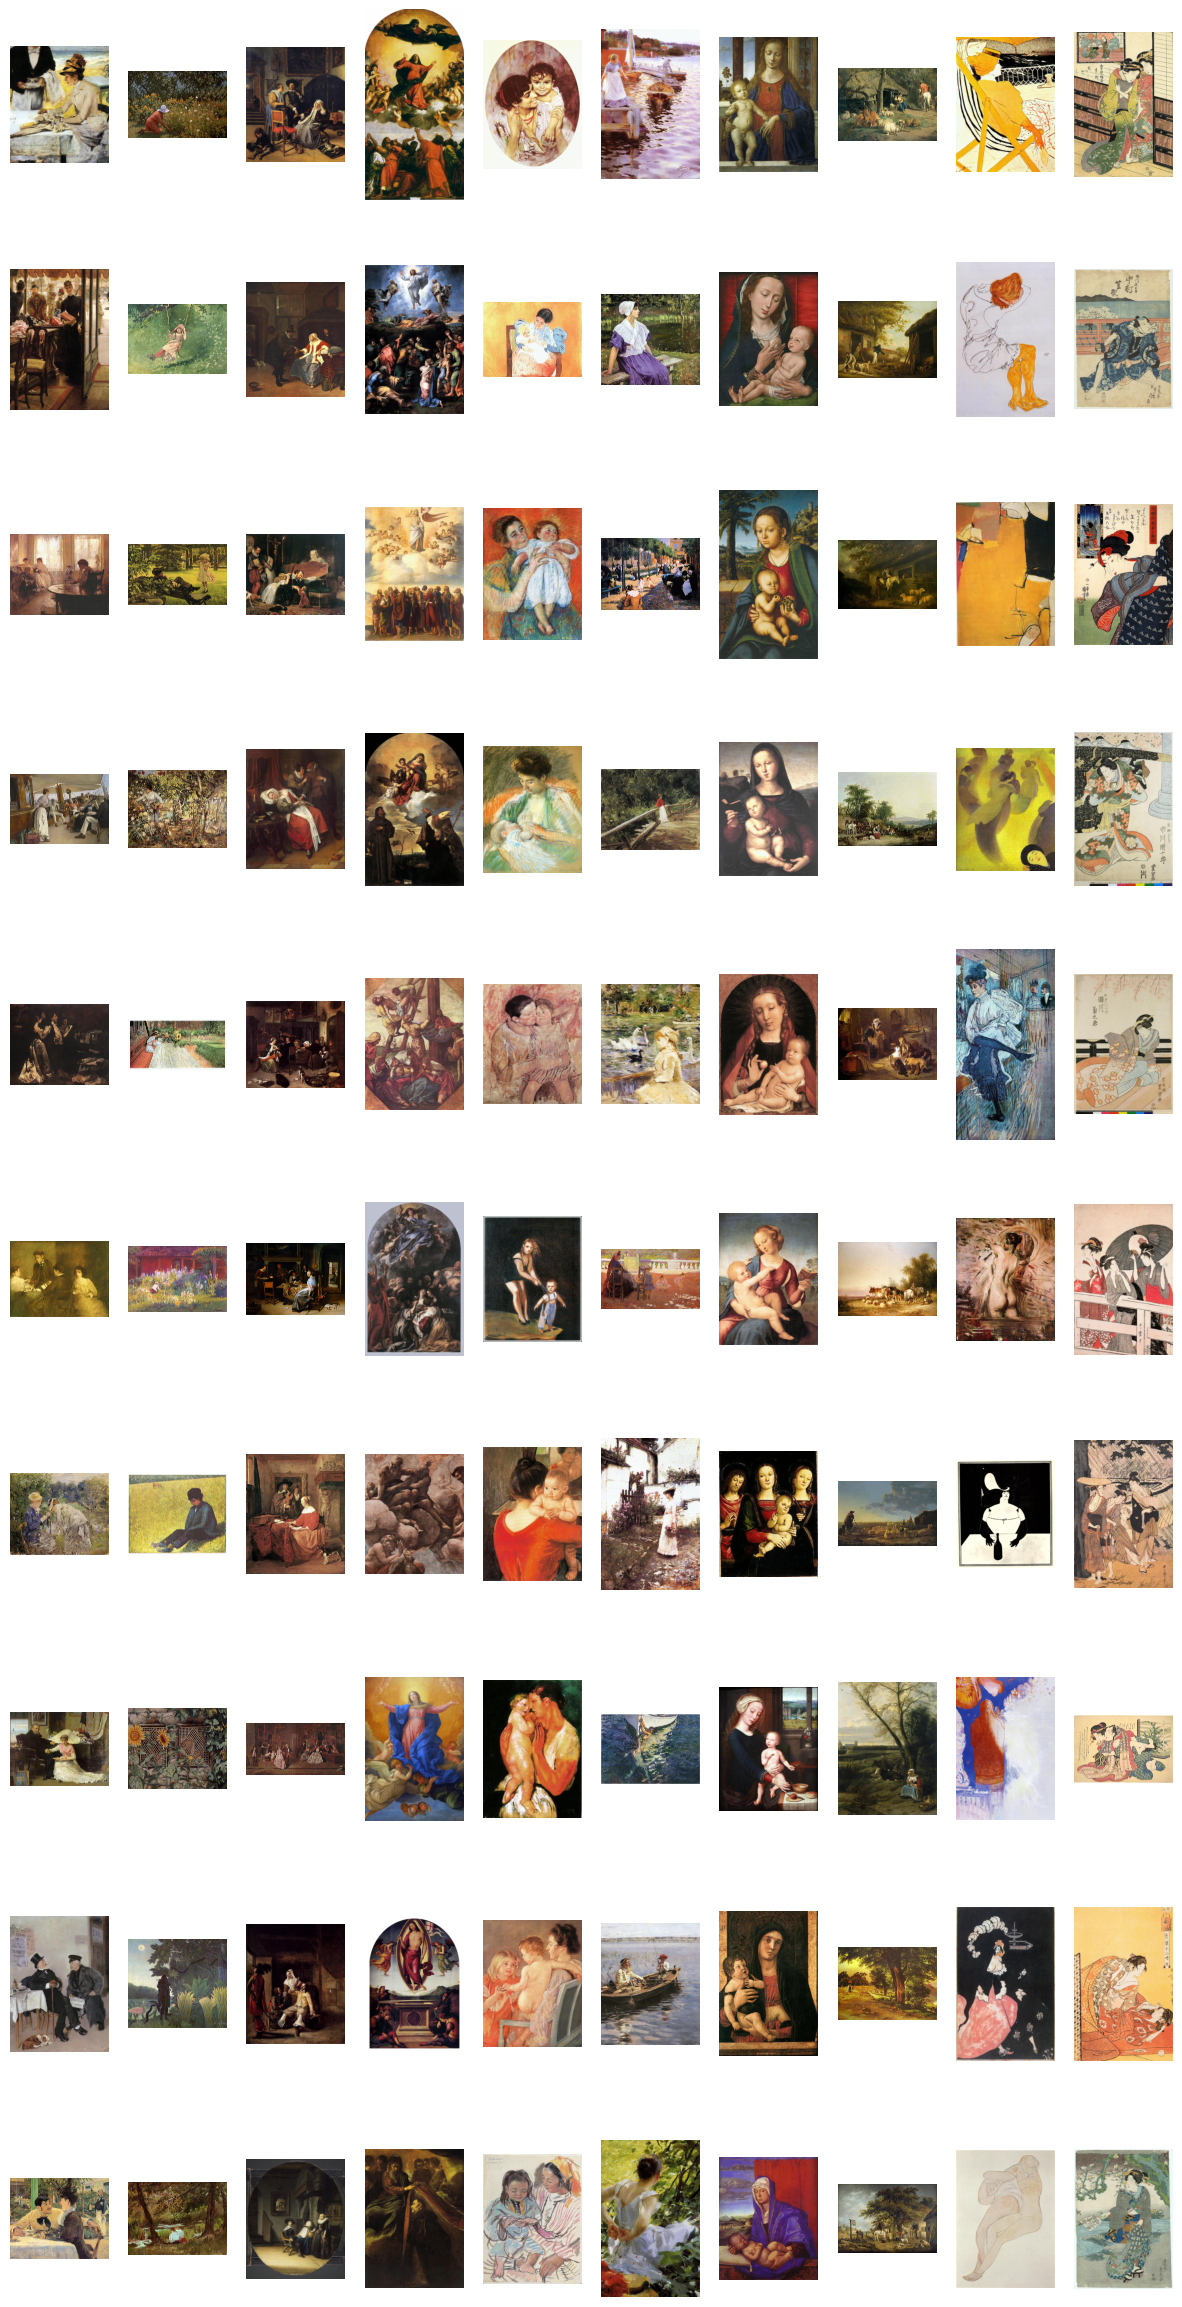

In [ ]:
random_images = random.sample(all_image_paths, 10)
prediction_image = [
    [
        str(project_root / res[0])
        for res in image_to_image(query_image=str(project_root / img_path), top_k=10)
    ]
    for img_path in random_images
]


draw_image_line([project_root / img_path for img_path in random_images])
print("Random images from the corpus")
print_separator()
draw_image_grid(prediction_image)

## 4. Просмотр примеров работы Caption2Image



Query text: A young boy on a horse




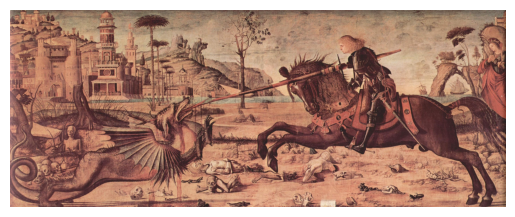

Unknown Artist | High_Renaissance | religious_painting | there is a painting of a man on a horse with a sword | Tags: mythological elements, interior scene, religious symbolism




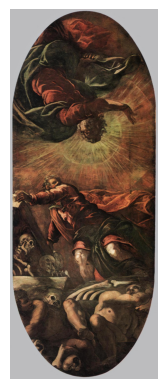

tintoretto | Mannerism_Late_Renaissance | religious_painting | there is a painting of a painting of a man on a horse | Tags: religious symbolism, interior scene, mythological elements




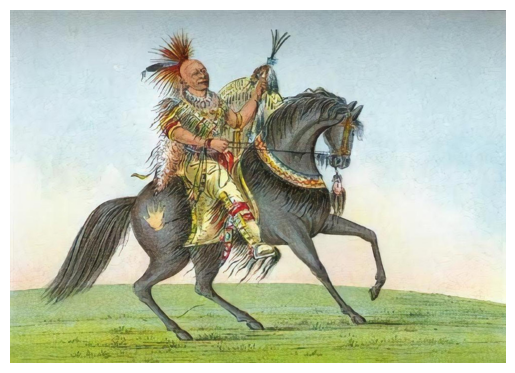

Unknown Artist | Realism | portrait | there is a drawing of a native man riding a horse | Tags: mythological elements, dynamic movement, interior scene




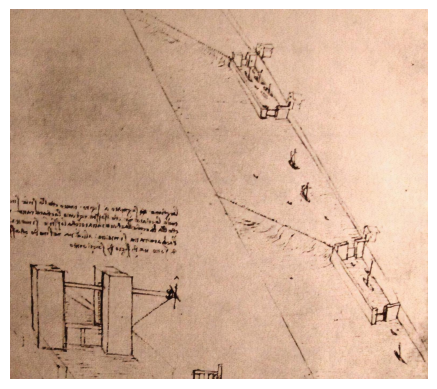

leonardo-da-vinci | High_Renaissance | sketch_and_study | drawing of a drawing of a man on a horse and a man on a horse | Tags: mythological elements, interior scene, dynamic movement




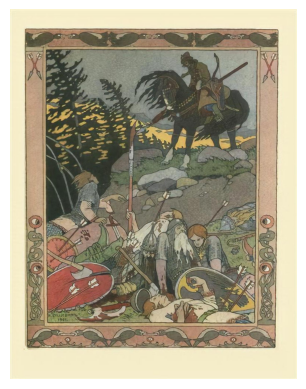

ivan-bilibin | Art_Nouveau | illustration | there is a picture of a painting of a man on a horse | Tags: mythological elements, interior scene, crowded scene




In [8]:
from demo import caption_to_image, set_new_mapping_location

set_new_mapping_location(project_root / "artifacts" / "type_mappings")

query_text = "A young boy on a horse"
result = caption_to_image(query_text=query_text, top_k=5)

print_separator()
print(f"Query text: {query_text}")
print_separator()
for img_path, description in result[::-1]:
    draw_image(str(img_path))
    print(description)
    print_separator()

Результаты относительно неплохие. В целом, система ошибается скорее на действительно сложных изображениях (описания к которыи довольно сомнительны), а также обладает слабой уверенностью (скорее всего это из-за спецификации возроста `young`).

In [ ]:
random_captions = random.sample(all_captions, 10)
prediction_image = [
    [
        str(project_root / res[0])
        for res in caption_to_image(query_text=caption, top_k=10)
    ]
    for caption in random_captions
]


white_image = np.ones((100, 100, 3), dtype=np.uint8) * 255

for i, caption in enumerate(random_captions):
    print(f"Caption {i + 1}: {caption}")
print("Random images from the corpus")
print_separator()
draw_image_grid(prediction_image)

NameError: name 'np' is not defined

## 5. Просмотр примеров работы Omni2Image



Query text: A young boy on a horse




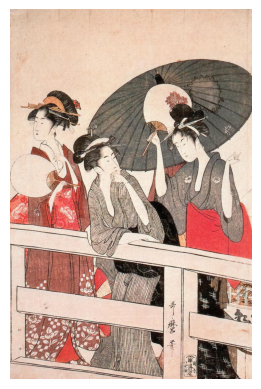

Generated caption:
there are three women standing on a bridge holding umbrellas
Rank 1:
ID: sample_3239
Artist: Unknown Artist
Style: Ukiyo_e
Genere: genre_painting
Score: 0.0584




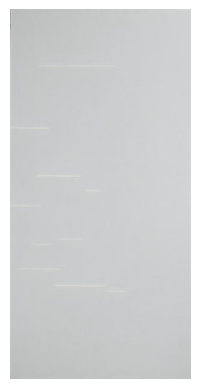

Generated caption:
there is a man that is standing in the snow with a snowboard
Rank 2:
ID: sample_1343
Artist: Unknown Artist
Style: Minimalism
Genere: abstract_painting
Score: 0.0571




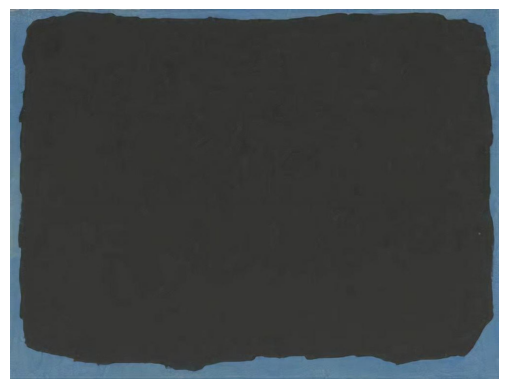

Generated caption:
an image of a black square on a blue background
Rank 3:
ID: sample_3911
Artist: Unknown Artist
Style: Minimalism
Genere: abstract_painting
Score: 0.0547




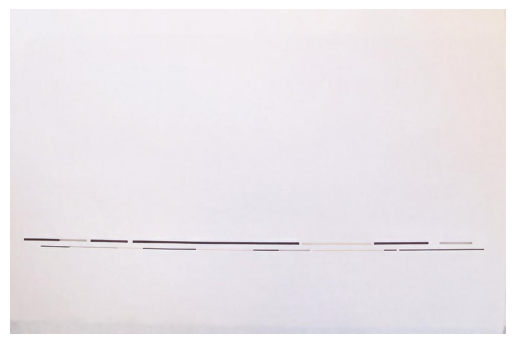

Generated caption:
there is a cat that is sitting on top of a refrigerator
Rank 4:
ID: sample_2750
Artist: Unknown Artist
Style: Minimalism
Genere: abstract_painting
Score: 0.0506




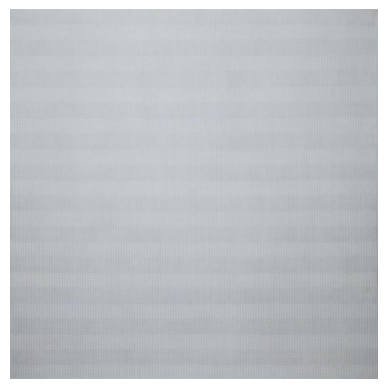

Generated caption:
there is a man that is standing on a surfboard in the water
Rank 5:
ID: sample_1028
Artist: Unknown Artist
Style: Minimalism
Genere: abstract_painting
Score: 0.0473




In [ ]:
from demo import omni_to_image, set_new_mapping_location

set_new_mapping_location(project_root / "artifacts" / "type_mappings")

query_text = "A young boy on a horse"
result = omni_to_image(query_text=query_text, styles=["7"], genres=["7"], tags=["boy", "horse"], top_k=5)

print_separator()
print(f"Query text: {query_text}")
print_separator()
for idx, (img_path, id, artist, style, genere, caption, score) in enumerate(result[::-1]):
    draw_image(str(img_path))
    print("Generated caption:")
    print(caption)
    print(f"Rank {idx + 1}:")
    print(f"ID: {id}")
    print(f"Artist: {artist}")
    print(f"Style: {style}")
    print(f"Genere: {genere}")
    print(f"Score: {score}")
    print_separator()